Import Libraries

In [3]:
import os
import jax
import jax.numpy as jnp
import jax.nn as jnn
import flax.nnx as nnx
from flax import struct
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Any
import jraph
from itertools import combinations
import meshio
import numpy as np
from dataclasses import dataclass

Hyper Params

In [ ]:
Epochs = 50
alpha = 1.0 ; gamma = 1.0 ; lambda_ = 1.0
beta_1 = 0.9 ; beta_2 = 0.999
batch_size = 10 
train_split = 0.9 ; CV_split = 0.05 ; test_split = 0.05
Learn_Rate = 0.001

RNG key

In [6]:
seed = 42 # This can be changed but is here to make the results easy to reproduce
base_key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(base_key)

Graph gen

In [ ]:
def Get_known(boundary_points, points):
    is_known = jnp.zeros(points.shape[0]) 
    is_known = is_known.at[boundary_points].set(1)
    return is_known

def build_send_receive(cell):
    sender_array = []
    receiver_array = []
    for edge in combinations(cell,2):
        sender_array.append(edge[0])
        receiver_array.append(edge[1])
    return sender_array, receiver_array

def build_graphs(senders, receivers, positions, boundary_points, U) -> jraph.GraphsTuple:
    is_known = Get_known(boundary_points, positions)
    U_applied = jnp.zeros_like(U).at[boundary_points].set(U[boundary_points])
        
    node_features = jnp.concatenate([positions, U_applied, jnp.expand_dims(is_known, axis=1)], axis=1)
    num_nodes = positions.shape[0]

    graph = jraph.GraphsTuple(
        nodes=node_features,
        senders=senders,
        receivers=receivers,
        edges=None,
        globals=None, 
        n_node=jnp.array([num_nodes]),
        n_edge=jnp.array([len(senders)])
    )
    return graph

import data

In [ ]:
# Define the path to your result file
filepath = os.path.join('data', 'vtk', 'u_final.vtu')

if not os.path.exists(filepath):
    print(f"Error: '{filepath}' not found. Please check the file path.")
else:
    mesh = meshio.read(filepath)

    positions = mesh.points
    right_face_indices = np.where(np.isclose(positions[:, 0], 1.0))[0]
    element_connectivity = mesh.cells[0].data

    unique_edges = set()

    for element in element_connectivity:
        element_senders, element_receivers = build_send_receive(element)
        
        for i in range(len(element_senders)):
            edge = tuple(sorted((element_senders[i], element_receivers[i])))
            unique_edges.add(edge)

    edge_list = jnp.array(list(unique_edges))
    senders = edge_list[:, 0]
    receivers = edge_list[:, 1]

    on_face_x0 = np.isclose(positions[:, 0], 0.0)
    on_face_x1 = np.isclose(positions[:, 0], 1.0)
    on_face_y0 = np.isclose(positions[:, 1], 0.0)
    on_face_y1 = np.isclose(positions[:, 1], 1.0)
    on_face_z0 = np.isclose(positions[:, 2], 0.0)
    on_face_z1 = np.isclose(positions[:, 2], 1.0)

    is_on_any_face = (on_face_x0 | on_face_x1 |
                      on_face_y0 | on_face_y1 |
                      on_face_z0 | on_face_z1)

    boundary_nodes_ = np.where(is_on_any_face)[0]

    print("Data extraction complete.\n")
    print(f"Positions array shape: {positions.shape}")
    print(f"Boundary indices array shape: {boundary_nodes_.shape}")
    print(f"Senders array shape: {senders.shape}")
    print(f"Receivers array shape: {receivers.shape}")

    print(boundary_nodes_)

Data extraction complete.

Positions array shape: (1331, 3)
Boundary indices array shape: (602,)
Senders array shape: (14230,)
Receivers array shape: (14230,)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 2

Unpickling the data

In [44]:
import sys
import types
import pickle

fake_module = types.ModuleType("DataSetup")

class DataStore:
    def __init__(self):
        pass

fake_module.DataStore = DataStore

sys.modules["DataSetup"] = fake_module

data_file = r"/home/samuel/Github/Research-Placement/data/simulation_results.pkl"

try:
    with open(data_file, "rb") as f:
        data_unpickled_1 = pickle.load(f)
    print(f"Successfully unpickled data.")
except FileNotFoundError:
    print(f"Error: File not found at {data_file}")
    dataset_list = {}

dataset_dict = data_unpickled_1

# Not tunable, is known from how many sims ran
num_sims = 10
# permutation list for batching
index_list = jnp.arange(num_sims)
permutated_index_list = jax.random.permutation(jax.random.PRNGKey(0), index_list)

Successfully unpickled data.


check data

In [45]:
print(dataset_dict[0]['boundary_strain_energy_gradient'].shape)
print(dataset_dict[0]['full_displacement_vector'].shape)
print(dataset_dict[0]['strain_energy'].shape)
print(dataset_dict[0]['applied_boundary_displacements'].shape)

print(dataset_dict[0]['boundary_strain_energy_gradient'])
print(dataset_dict[0]['full_displacement_vector'])
print(dataset_dict[0]['strain_energy'])

(1806, 3)
(1331, 3)
()
(1806, 3)
[[-2.9210228e-04 -6.3567061e-04 -1.4251155e-03]
 [-4.4415184e-04  8.9642766e-05 -6.0152575e-05]
 [-3.8378930e-04 -1.0108644e-04 -1.7809425e-05]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]
[[-3.3549329e-03 -6.5468852e-03 -1.0724306e-03]
 [-3.3549329e-03 -6.5468852e-03 -1.0724306e-03]
 [-3.3549329e-03 -6.5468852e-03 -1.0724306e-03]
 ...
 [ 1.5876233e-03 -1.5465567e-04 -2.3625712e-03]
 [ 1.4152135e-03 -4.2626876e-04 -3.6217444e-04]
 [ 2.9660708e-03  7.4987329e-05  4.9074343e-03]]
0.004835612


Pre-processing functions - Need to be changed when preprocessing is implemented to accomodate the data format

In [46]:
def mean_and_std_dev(data,*,train_split):
    split_idx = int(data.shape[0] * train_split)
    train_data = data[:split_idx]
    mean = jnp.mean(train_data, axis=0)
    std_dev = jnp.std(train_data, axis=0)
    return {'mean':mean, 'std_dev':std_dev}

def scale_data(data,*, data_params):
    return (data - data_params['mean']) / data_params['std_dev']
    
def unscale_data(data,*,data_params):
    return (data * data_params['std_dev']) + data_params['mean']

Data pre-processing and graph building

In [ ]:
# Pre-processing
boundary_nodes = jnp.array(dataset_dict[0]['node_to_disp_map'].keys())
processed_dataset_dict = dataset_dict

graphs_list = []
displacements_list = []
target_e_list = []
target_e_prime_list = []
boundary_displacements_list = []

# Graph Building
for i in tqdm(range(num_sims), leave=False):
    U = processed_dataset_dict[i]['full_displacement_vector']
    U = jnp.array(U)
    bdd = jnp.array(processed_dataset_dict[i]['node_to_disp_map'].items())
    boundary_displacements_list.append(bdd)
    graph = build_graphs(
        senders, 
        receivers, 
        positions, 
        boundary_nodes, 
        U
    )
    graphs_list.append(graph)
    displacements_list.append(U)
    target_e = jnp.array(processed_dataset_dict[i]['strain_energy'])
    target_e_list.append(target_e)
    target_e_prime = jnp.array(processed_dataset_dict[i]['node_to_grad_map'].items())
    target_e_prime_list.append(target_e_prime)

dataset = {
    'graphs_list': graphs_list,
    'displacements': displacements_list,
    'target_e': target_e_list,
    'target_e_prime': target_e_prime_list,
    'boundary_displacements': boundary_displacements_list,
    'boundary_nodes_indices': boundary_nodes
}

Batching functions

In [ ]:
def batch_and_split_dataset(dataset_dict, batch_size, train_split, CV_split, test_split, permutated_index_list):
    total_samples = permutated_index_list.shape[0]
    idx_train_samples = int(train_split * total_samples) 
    idx_test_samples = idx_train_samples + int(test_split * total_samples) 

    train_idx = list(permutated_index_list[:idx_train_samples])
    test_idx = list(permutated_index_list[idx_train_samples:idx_test_samples])
    CV_idx = list(permutated_index_list[idx_test_samples:])

    def batch_indices(idx):  
        if not idx:
            return
        num_samples = len(idx)
        num_batches = num_samples // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            batch_idx = idx[start:end]
            
            graphs_in_batch = [dataset_dict['graphs_list'][i] for i in batch_idx]
            displacements_batch = [dataset_dict['displacements'][i] for i in batch_idx]
            e_batch = [dataset_dict['target_e'][i] for i in batch_idx]
            e_prime_batch = [dataset_dict['target_e_prime'][i] for i in batch_idx]

            batched_graphs = graphs_in_batch
            batched_displacements = jnp.array(displacements_batch)
            batched_e = jnp.array(e_batch)
            batched_e_prime = jnp.array(e_prime_batch)

            yield {
                'graphs': batched_graphs, 
                'displacements': batched_displacements, 
                'target_e': batched_e, 
                'target_e_prime': batched_e_prime
            }
    
    train_batches = list(batch_indices(train_idx))
    test_batches = list(batch_indices(test_idx))
    CV_batches = list(batch_indices(CV_idx))

    return train_batches, CV_batches, test_batches


Batching graphs

In [49]:
train_batches, CV_batches, test_batches = batch_and_split_dataset(
    dataset, 
    batch_size, 
    train_split, 
    CV_split, 
    test_split, 
    permutated_index_list
)

is_known_zero = Get_known(boundary_nodes, positions)
is_known_zero_expanded = jnp.expand_dims(is_known_zero, axis=1)
U_zero = jnp.zeros_like(positions)
node_features_zero = jnp.concatenate([positions, U_zero, is_known_zero_expanded], axis=1)

zero_graph = jraph.GraphsTuple(
    nodes=node_features_zero,
    senders=senders,
    receivers=receivers,
    edges=None,
    globals=None, 
    n_node=jnp.array([positions.shape[0]]),
    n_edge=jnp.array([len(senders)])
)

zero_list = []

for i in range(batch_size):
    zero_list.append(zero_graph)

batched_zero_graph = jraph.batch(zero_list)

GAT Layer

In [ ]:
@dataclass
class GATEdges:
    score: jax.Array
    message: jax.Array

class GAT(nnx.Module):
    def __init__(self, in_features, out_features, *, rngs):
        self.in_features = in_features
        self.out_features = out_features

        self.GNN = jraph.GraphNetwork(
            update_edge_fn=self.update_edge_fn,
            update_node_fn=self.update_node_fn,
            aggregate_edges_for_nodes_fn=self.aggregate_edges_for_nodes_fn
        )

        initialiser = nnx.initializers.lecun_normal()
        self.Weight_mat = nnx.Param(initialiser(rngs.params(), (in_features, out_features)))
        self.Attention_mat = nnx.Param(initialiser(rngs.params(), (2 * out_features, 1)))

    def update_edge_fn(self, edges, senders, receivers, globals_):
        "computes edge features and outputs a dict containing the edge features"
        h_sender = senders @ self.Weight_mat
        h_reciever = receivers @ self.Weight_mat

        send_recieve_features = jnp.concatenate([h_sender, h_reciever], axis=-1)
        attention_scores = nnx.leaky_relu(send_recieve_features @ self.Attention_mat)

        return GATEdges(score=attention_scores, message=h_sender)
    
    def aggregate_edges_for_nodes_fn(self, edges: GATEdges, segment_ids, num_segments) -> jax.Array:
        "aggregates all edge messages for a node and outputs the aggregated messages"
        attention_coeffs = jraph.segment_softmax(
            logits=edges.score,
            segment_ids=segment_ids,
            num_segments=num_segments
        )

        weighted_messages = edges.message * attention_coeffs

        aggregated_messages = jraph.segment_mean(
            data=weighted_messages,
            segment_ids=segment_ids, 
            num_segments=num_segments
        )

        return aggregated_messages

    def update_node_fn(self, nodes, sent_edges, received_edges, globals_):
        "takes aggregated node messages and applies them to the graph"
        return received_edges

    def __call__(self, graph):
        return self.GNN(graph)

Block Coarsening 

In [ ]:
class BlockCoursening(nnx.Module): 
    def __init__(self, block_size, *, rngs: nnx.Rngs):
        self.block_dims = block_size

    def partition(self, node_coords):
        min_coords = jnp.min(node_coords, axis=0)
        max_coords = jnp.max(node_coords, axis=0)
        grid_cell_size = (max_coords - min_coords) / jnp.array(self.block_dims)
        relative_coords = node_coords - min_coords

        normalized_coords = relative_coords / grid_cell_size
        grid_indices = jnp.floor(normalized_coords).astype(jnp.int32)
    
        grid_indices = jnp.clip(grid_indices, 0, jnp.array(self.block_dims) - 1)
    
        block_ids = (grid_indices[:, 0] * self.block_dims[1] * self.block_dims[2] + 
                 grid_indices[:, 1] * self.block_dims[2] + 
                 grid_indices[:, 2]
            )
    
        return block_ids
    
    def __call__(self, graph: jraph.GraphsTuple, node_coords):
        block_ids = self.partition(node_coords)
        num_blocks = jnp.max(block_ids) + 1

        coarsened_nodes = jraph.segment_mean(
            data=graph.nodes,
            segment_ids=block_ids,
            num_segments=num_blocks
        )

        block_senders = block_ids[graph.senders]
        block_receivers = block_ids[graph.receivers]

        inter_block_mask = block_senders != block_receivers
        coarsened_senders_unfiltered = block_senders[inter_block_mask]
        coarsened_receivers_unfiltered = block_receivers[inter_block_mask]

        hashed_edge_ids = coarsened_senders_unfiltered * num_blocks + coarsened_receivers_unfiltered
        unique_edge_ids = jnp.unique(hashed_edge_ids)

        coarsened_senders = unique_edge_ids // num_blocks
        coarsened_receivers = unique_edge_ids % num_blocks
        coarsened_edges = jnp.ones(shape=(coarsened_senders.shape[0], 1))
        
        pooled_graph = jraph.GraphsTuple(
            nodes=coarsened_nodes,
            edges=coarsened_edges,
            senders=coarsened_senders,
            receivers=coarsened_receivers,
            n_edge=jnp.array([coarsened_edges.shape[0]]),
            n_node=jnp.array([num_blocks]),
            globals=None
        )
        return pooled_graph

Model

In [ ]:
class GNN(nnx.Module):
    def __init__(self, node_feature_dim: int, embedding_dim: int, output_dim: int, pooling_block_dims_1, rngs: nnx.Rngs):
        self.embedding_layer = nnx.Linear(node_feature_dim, embedding_dim, rngs=rngs)
        self.encoderL1 = GAT(embedding_dim, embedding_dim, rngs=rngs)
        self.BatchNormL1 = nnx.BatchNorm(num_features=embedding_dim, rngs=rngs)
        self.encoderL2 = GAT(embedding_dim, embedding_dim, rngs=rngs)
        self.BatchNormL2 = nnx.BatchNorm(num_features=embedding_dim, rngs=rngs)
        self.encoderL3 = GAT(embedding_dim, embedding_dim, rngs=rngs)
        self.decoding_layer = nnx.Linear(embedding_dim, output_dim, rngs=rngs)
        self.poolingLayer1 = BlockCoursening(pooling_block_dims_1, rngs=rngs)
    
    def embedder(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Maps current node features to higher dimensional node embeddings"""
        nodes = graph.nodes
        embeddings = self.embedding_layer(nodes)
        return graph._replace(nodes=embeddings)
    
    def apply_activation_and_res(self, graph: jraph.GraphsTuple, residual: jax.Array) -> jraph.GraphsTuple:
        """Applies activation function and residual to the graph"""
        nodes = graph.nodes
        activated_nodes = nnx.silu(nodes) + residual
        return graph._replace(nodes=activated_nodes)
    
    def apply_res(self, graph: jraph.GraphsTuple, residual: jax.Array) -> jraph.GraphsTuple:
        """Applies activation_function to the graph"""
        new_nodes = graph.nodes + residual
        return graph._replace(nodes=new_nodes)
        
    def decoder(self, graph: jraph.GraphsTuple) -> jax.Array: 
        """Takes processed graph and aggregates nodes then passes them through the decoding layer to predict energy"""
        num_nodes = graph.nodes.shape[0]
        node_graph_indices = jnp.zeros(num_nodes)
        aggregate_nodes = jraph.segment_sum(
            data=graph.nodes, 
            segment_ids=node_graph_indices,
            num_segments=1
        )
        return self.decoding_layer(aggregate_nodes)
        
    def forward_pass(self, G: jraph.GraphsTuple, use_running_average: bool) -> jax.Array:
        """Takes a graph and passes it through the GNN to predict energy"""
        node_coords = G.nodes[:,0:3]
        G = self.embedder(G)
        res1 = G.nodes

        G = self.encoderL1(G)
        nodes_norm = self.BatchNormL1(
            G.nodes, 
            use_running_average=use_running_average
        )
        G = G._replace(nodes=nodes_norm)
        G = self.apply_activation_and_res(G, res1)
        G = self.poolingLayer1(G, node_coords)
        res2 = G.nodes

        G = self.encoderL2(G)
        nodes_norm = self.BatchNormL2(
            G.nodes,
            use_running_average=use_running_average
        )
        G = G._replace(nodes=nodes_norm)
        G = self.apply_activation_and_res(G, res2)
        res3 = G.nodes

        G = self.encoderL3(G)
        G = self.apply_res(G, res3)

        e = self.decoder(G)
        return e
    
    def call_single(self, G: jraph.GraphsTuple, use_running_average: bool):
        """Call the GNN for a single graph"""
        e = self.forward_pass(G, use_running_average)

        def energy_fn(nodes):
            G_temp = G._replace(nodes=nodes)
            result = self.forward_pass(G_temp, use_running_average=True)
            return result.squeeze()

        grad_fn = jax.grad(energy_fn)
        grads = grad_fn(G.nodes)
        e_prime = grads[:, 3:6]
        return e, e_prime
    
    def vmap_call(self, graphs_list: list, use_running_average: bool):
        "Process graphs using vmap. Faster than looped logic but requires graphs to have equal structure"
        stacked_nodes = jnp.stack([g.nodes for g in graphs_list])
        first_graph = graphs_list[0]
        
        batched_graph = jraph.GraphsTuple(
            nodes=stacked_nodes,  # Shape: (batch_size, num_nodes, num_features)
            senders=first_graph.senders, 
            receivers=first_graph.receivers,  
            edges=None,
            globals=None,
            n_node=first_graph.n_node,  
            n_edge=first_graph.n_edge   
        )
        
        vmapped_call = jax.vmap(self.call_single, in_axes=(0, None))
        e_batch, e_prime_batch = vmapped_call(batched_graph, use_running_average)
        return e_batch, e_prime_batch
    
    def __call__(self, graphs_list: list, use_running_average: bool):
        "Main call method with automatic selection"
        if len(graphs_list) == 1:
            e, e_prime = self.call_single(graphs_list[0], use_running_average)
            return jnp.expand_dims(e, 0), jnp.expand_dims(e_prime, 0)
    
        elif self.graphs_have_same_structure(graphs_list):
            return self.vmap_call(graphs_list, use_running_average)
        

Loss function and Optimiser

In [54]:
def loss_fn(batch, batched_zero_graph,*, Model, use_running_average, alpha, gamma, lam): 
    """
    Calculates the loss of a model, works to minimise the mean square error of both 
    the strain energy prediction and the strain energy derivative prediction,
    whilst forcing the function through zero.
    """
    target_e_batch = batch['target_e']
    target_e_prime_batch = batch['target_e_prime']
    graph_batch = batch['graphs']
    
    prediction_e, prediction_e_prime = Model(graph_batch, use_running_average)
    loss_e = jnp.mean((prediction_e - target_e_batch)**2)
    loss_e_prime = jnp.mean((prediction_e_prime - target_e_prime_batch)**2)
    
    prediction_zero, _ = Model(batched_zero_graph, use_running_average=False)
    loss_zero = jnp.mean((prediction_zero - 0.0)**2)

    return (alpha * loss_e + gamma * loss_e_prime + lam * loss_zero)

CV loss

In [ ]:
def CV_loss_fn(CV_batches, batched_zero_graph, Model: GNN, alpha, gamma, lambda_):
    CV_loss = 0
    batch_count = 0

    Model.eval()
    for CV_batch in CV_batches:
        batch_count += 1

        loss = loss_fn(
            CV_batch,
            batched_zero_graph,
            Model=Model,
            use_running_average=True,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_
        )

        CV_loss += loss

    if batch_count > 0:
        CV_loss = CV_loss / batch_count
        return CV_loss
    else:
        return 0

Train Step

In [56]:
@nnx.jit
def train_step(Model, optimiser, GraphandTarget_batch, batched_zero_graph, *, alpha, gamma, lambda_):

    def wrapped_loss(Model):
        loss = loss_fn(
            GraphandTarget_batch,
            batched_zero_graph,
            Model=Model,
            use_running_average=False,
            alpha=alpha,
            gamma=gamma,
            lam=lambda_ 
        )
        return loss
    
    loss, grads = nnx.value_and_grad(wrapped_loss, argnums=0)(Model)
    optimiser.update(grads)

    return loss

Train Loop

In [ ]:
Model = GNN(
    node_feature_dim=7, 
    embedding_dim=128,
    output_dim=1,
    pooling_block_dims_1=(2,2,2),
    rngs=rngs
)

optimiser = nnx.Optimizer(
    Model,
    optax.adam(
        learning_rate=Learn_Rate, 
        b1=beta_1, 
        b2=beta_2
    ),
    wrt=nnx.Param
)

loss_record = []
CV_loss_record = []

for epoch in range(Epochs):
    running_loss = 0.0
    batch_count = 0
    for batch in tqdm(train_batches, desc=f"Epoch {epoch}/{Epochs}", leave=False):
        Model.train()
        batch_loss = train_step(
            Model,
            optimiser,
            batch,
            batched_zero_graph,
            alpha=alpha,
            gamma=gamma,
            lambda_=lambda_
        )

        batch_count += 1
        running_loss += batch_loss

    CV_loss = CV_loss_fn(
        CV_batches,
        batched_zero_graph,
        Model,
        alpha,
        gamma,
        lambda_
    )
    
    loss_record.append(running_loss)
    CV_loss_record.append(CV_loss)


Epoch 0/50:   0%|          | 0/9 [00:00<?, ?it/s]

ValueError: Incompatible shapes for broadcasting: shapes=[(1331, 3), (1, 1806, 3)]

plot

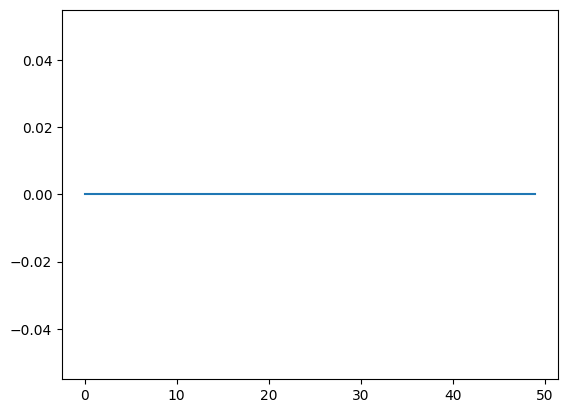

In [ ]:
plt.plot(loss_record)